# Predicting FPGA Power Consumption And Power Optimization Using AI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC,SVR
import joblib
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Dataset/cleaned_latency_summary.csv')
df

,Kernel Name,Number Of Runs,CU Full Name,Minimum Time (ms),Average Time (ms),Maximum Time (ms),PowerConsumption,DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s)
0,ResidualBlock-in_96x14x14-out_136-k_7-e_3-s_1-...,500,DPUCZDX8G_1:batch-1,0.708000,0.719000,0.868000,0.032000,10.596000,0.162000,244.496000
1,ResidualBlock-in_96x14x14-out_96-k_5-e_3-s_1-a...,500,DPUCZDX8G_1:batch-1,0.477000,0.488000,0.816000,0.025000,12.615000,0.114000,266.378000
2,ResidualBlock-in_48x28x28-out_48-k_3-e_3-s_1-a...,500,DPUCZDX8G_1:batch-1,0.354000,0.365000,0.876000,0.024000,17.225000,0.134000,437.257000
3,ResidualBlock-in_96x14x14-out_96-k_5-e_6-s_1-a...,500,DPUCZDX8G_1:batch-1,0.919000,0.928000,1.069000,0.050000,12.400000,0.174000,200.180000
4,ResidualBlock-in_136x14x14-out_192-k_5-e_6-s_2...,500,DPUCZDX8G_1:batch-1,1.320000,1.326000,1.420000,0.062000,10.628000,1.040000,818.669000
...,...,...,...,...,...,...,...,...,...,...
2251,ResidualBlock-in_48x28x28-out_48-k_3-e_6-s_1-a...,500,DPUCZDX8G_1:batch-1,1.160655,1.735937,1.185987,0.017823,6.896625,0.110000,978.585087
2252,ResidualBlock-in_136x14x14-out_136-k_7-e_3-s_1...,500,DPUCZDX8G_1:batch-1,0.390740,1.024705,2.329575,0.051622,13.109634,1.730000,148.121000
2253,ResidualBlock-in_32x56x56-out_32-k_5-e_6-s_1-a...,500,DPUCZDX8G_1:batch-1,1.378225,0.336410,0.486000,0.070198,11.755723,0.113835,985.647820
2254,ResidualBlock-in_32x56x56-out_48-k_5-e_6-s_2-a...,500,DPUCZDX8G_1:batch-1,0.915216,1.534690,1.318802,0.061656,5.678766,0.632615,855.769426


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Kernel Name             2256 non-null   object 
 1   Number Of Runs          2256 non-null   int64  
 2   CU Full Name            2256 non-null   object 
 3   Minimum Time (ms)       2256 non-null   float64
 4   Average Time (ms)       2256 non-null   float64
 5   Maximum Time (ms)       2256 non-null   float64
 6   PowerConsumption        2256 non-null   float64
 7   DPU Performance(GOP/s)  2256 non-null   float64
 8   Mem IO(MB)              2256 non-null   float64
 9   Mem Bandwidth(MB/s)     2256 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 176.4+ KB


In [4]:
df.isnull().sum()

Kernel Name               0
Number Of Runs            0
CU Full Name              0
Minimum Time (ms)         0
Average Time (ms)         0
Maximum Time (ms)         0
PowerConsumption          0
DPU Performance(GOP/s)    0
Mem IO(MB)                0
Mem Bandwidth(MB/s)       0
dtype: int64

In [5]:
df.duplicated().sum()

1659

In [6]:
df.describe()

,Number Of Runs,Minimum Time (ms),Average Time (ms),Maximum Time (ms),PowerConsumption,DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s)
count,2256.0,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000
mean,500.0,1.082522,1.090817,1.456798,0.049646,12.101033,0.625324,645.853336
std,0.0,0.562671,0.552977,0.720199,0.028628,4.676969,0.446569,373.520249
min,500.0,0.312000,0.318000,0.486000,0.003000,0.730000,0.110000,148.121000
25%,500.0,0.637148,0.634511,0.900221,0.028953,9.021518,0.208564,324.071000
50%,500.0,1.035667,1.078347,1.333314,0.047734,11.847727,0.567269,614.798385
75%,500.0,1.447878,1.458809,1.884000,0.067828,15.322106,0.931879,890.009719
max,500.0,3.741000,3.754000,4.766000,0.162000,25.527000,1.730000,1923.635000


In [7]:
le = LabelEncoder()

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = le.fit_transform(df[column])

In [8]:
df

,Kernel Name,Number Of Runs,CU Full Name,Minimum Time (ms),Average Time (ms),Maximum Time (ms),PowerConsumption,DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s)
0,85,500,0,0.708000,0.719000,0.868000,0.032000,10.596000,0.162000,244.496000
1,91,500,0,0.477000,0.488000,0.816000,0.025000,12.615000,0.114000,266.378000
2,61,500,0,0.354000,0.365000,0.876000,0.024000,17.225000,0.134000,437.257000
3,93,500,0,0.919000,0.928000,1.069000,0.050000,12.400000,0.174000,200.180000
4,18,500,0,1.320000,1.326000,1.420000,0.062000,10.628000,1.040000,818.669000
...,...,...,...,...,...,...,...,...,...,...
2251,63,500,0,1.160655,1.735937,1.185987,0.017823,6.896625,0.110000,978.585087
2252,10,500,0,0.390740,1.024705,2.329575,0.051622,13.109634,1.730000,148.121000
2253,48,500,0,1.378225,0.336410,0.486000,0.070198,11.755723,0.113835,985.647820
2254,57,500,0,0.915216,1.534690,1.318802,0.061656,5.678766,0.632615,855.769426


In [9]:
x = df.drop(['PowerConsumption'],axis=1)
x

,Kernel Name,Number Of Runs,CU Full Name,Minimum Time (ms),Average Time (ms),Maximum Time (ms),DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s)
0,85,500,0,0.708000,0.719000,0.868000,10.596000,0.162000,244.496000
1,91,500,0,0.477000,0.488000,0.816000,12.615000,0.114000,266.378000
2,61,500,0,0.354000,0.365000,0.876000,17.225000,0.134000,437.257000
3,93,500,0,0.919000,0.928000,1.069000,12.400000,0.174000,200.180000
4,18,500,0,1.320000,1.326000,1.420000,10.628000,1.040000,818.669000
...,...,...,...,...,...,...,...,...,...
2251,63,500,0,1.160655,1.735937,1.185987,6.896625,0.110000,978.585087
2252,10,500,0,0.390740,1.024705,2.329575,13.109634,1.730000,148.121000
2253,48,500,0,1.378225,0.336410,0.486000,11.755723,0.113835,985.647820
2254,57,500,0,0.915216,1.534690,1.318802,5.678766,0.632615,855.769426


In [10]:
y = df['PowerConsumption']
y

0       0.032000
1       0.025000
2       0.024000
3       0.050000
4       0.062000
          ...   
2251    0.017823
2252    0.051622
2253    0.070198
2254    0.061656
2255    0.048766
Name: PowerConsumption, Length: 2256, dtype: float64

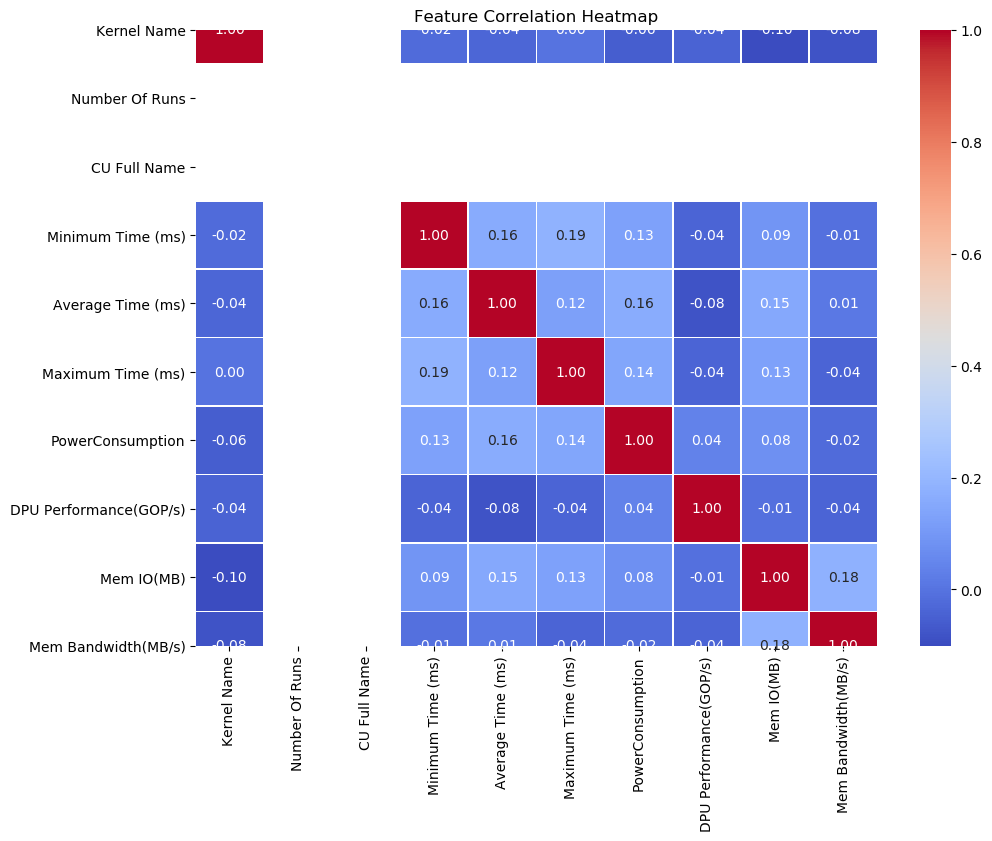

In [11]:
# Plot the heatmap
plt.figure(figsize=(11, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

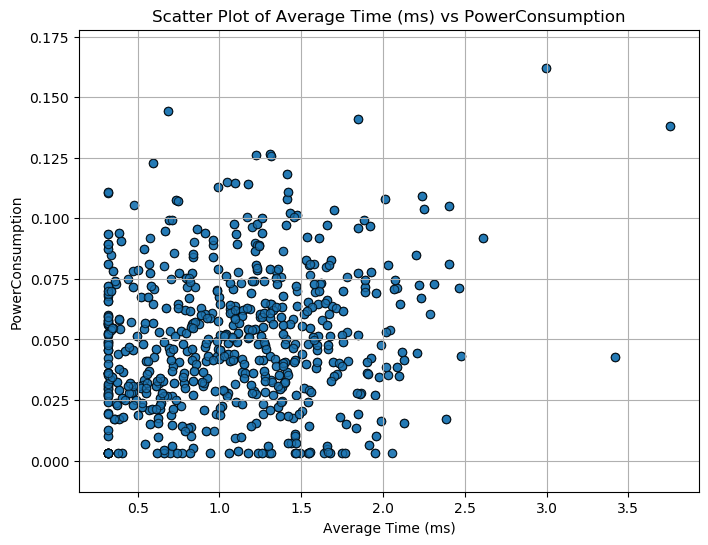

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Average Time (ms)'], y=df['PowerConsumption'], alpha=0.6, edgecolor='black')

plt.xlabel('Average Time (ms)')
plt.ylabel('PowerConsumption')
plt.title(f"Scatter Plot of {'Average Time (ms)'} vs {'PowerConsumption'}")
plt.grid(True)
plt.show()

In [13]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77)

In [14]:
x_train.shape

(1804, 9)

In [15]:
y_train.shape

(1804,)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate regression metrics
def calculateRegressionMetrics(algorithm, predict, testY):
    # Calculate metrics
    mae = mean_absolute_error(testY, predict)
    mse = mean_squared_error(testY, predict)
    rmse = np.sqrt(mse)
    r2 = r2_score(testY, predict)
    
    # Print metrics
    print(f"{algorithm} Mean Absolute Error (MAE): {mae:.2f}")
    print(f"{algorithm} Mean Squared Error (MSE): {mse:.2f}")
    print(f"{algorithm} Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"{algorithm} R2 Score: {r2:.2f}")
    
    # Scatter plot of actual vs predicted values
    plt.figure(figsize=(7, 7))
    plt.scatter(testY, predict, color='blue', alpha=0.6)
    plt.plot([min(testY), max(testY)], [min(testY), max(testY)], color='red', linestyle='--', linewidth=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{algorithm} Predicted vs Actual Values")
    plt.grid(True)
    plt.show()

Model loaded successfully.
Linear Regression Mean Absolute Error (MAE): 0.02
Linear Regression Mean Squared Error (MSE): 0.00
Linear Regression Root Mean Squared Error (RMSE): 0.03
Linear Regression R2 Score: 0.04


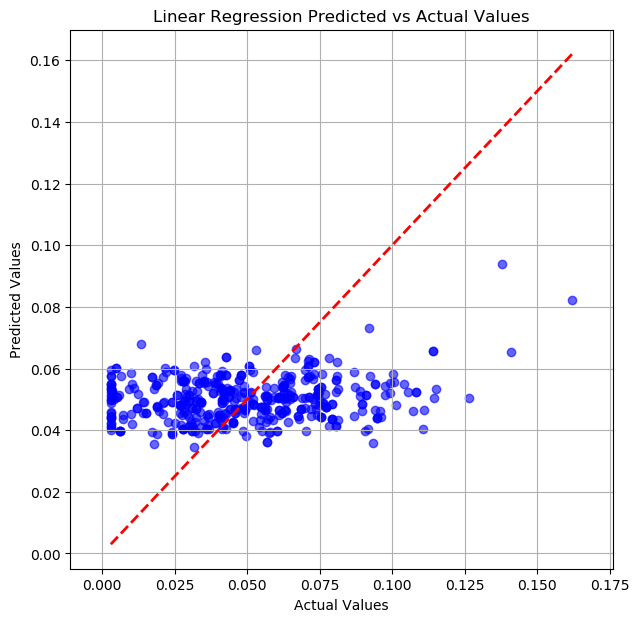

In [18]:
from sklearn.linear_model import LinearRegression
modelfile = 'model/LR.pkl'
if os.path.exists(modelfile):
    model = joblib.load(modelfile)
    print("Model loaded successfully.")
    predict = model.predict(x_test)
    calculateRegressionMetrics("Linear Regression", predict, y_test)
else:
    model = LinearRegression()
    model.fit(x_train, y_train)
    joblib.dump(model, modelfile) 
    print("Model saved successfully.")
    predict = model.predict(x_test)
    calculateRegressionMetrics("Linear Regression", predict, y_test)

Bayesian Ridge Regression Mean Absolute Error (MAE): 0.02
Bayesian Ridge Regression Mean Squared Error (MSE): 0.00
Bayesian Ridge Regression Root Mean Squared Error (RMSE): 0.03
Bayesian Ridge Regression R2 Score: 0.04


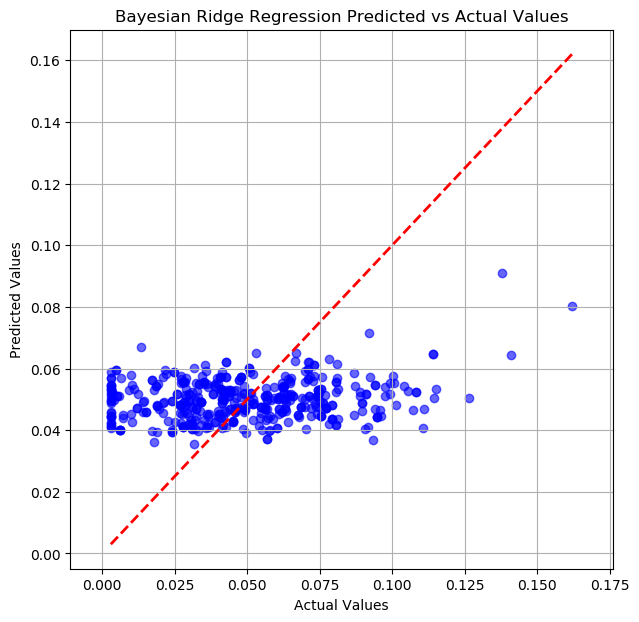

In [19]:
from sklearn.linear_model import BayesianRidge
import joblib
import os

model = 'model/bayesian_ridge_regressor.pkl'

if os.path.exists(model):
    # Load the model from the pkl file
    bayesian_ridge_regressor = joblib.load(model)
    predict = bayesian_ridge_regressor.predict(x_test)
    calculateRegressionMetrics("Bayesian Ridge Regression", predict, y_test)
else:
    bayesian_ridge_regressor = BayesianRidge(    alpha_1=1e-6,         # Hyperparameter for alpha (smaller values allow more flexibility)
    alpha_2=1e-6,         # Second hyperparameter for alpha
    lambda_1=1e-6,        # Hyperparameter for lambda (controls L2 regularization)
    lambda_2=1e-6,        # Second hyperparameter for lambda
    tol=1e-4,             # Convergence tolerance (lower values give more precise results)
    compute_score=True,   # Tracks log-likelihood score (useful for evaluation)
    fit_intercept=True)
    # Train the regressor on the training data
    bayesian_ridge_regressor.fit(x_train, y_train)
    # Make predictions on the test data
    predict = bayesian_ridge_regressor.predict(x_test)
    joblib.dump(bayesian_ridge_regressor, model)
    print("Bayesian Ridge Regression trained and model weights saved.")
    calculateRegressionMetrics("Bayesian Ridge Regression", predict, y_test)

KNN Regressor Mean Absolute Error (MAE): 0.02
KNN Regressor Mean Squared Error (MSE): 0.00
KNN Regressor Root Mean Squared Error (RMSE): 0.02
KNN Regressor R2 Score: 0.42


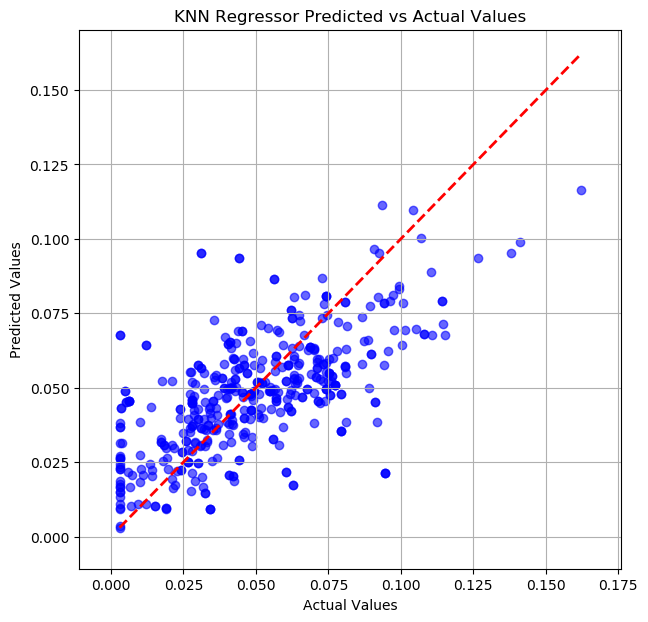

In [20]:
from sklearn.neighbors import KNeighborsRegressor
model = 'model/knn_regressor.pkl'
if os.path.exists(model):
    # Load the model from the pkl file
    knn_regressor = joblib.load(model)
    predict = knn_regressor.predict(x_test)
    calculateRegressionMetrics("KNN Regressor", predict, y_test)
else:
    knn_regressor = KNeighborsRegressor()
    # Train the regressor on the training data
    knn_regressor.fit(x_train, y_train)
    # Make predictions on the test data
    predict = knn_regressor.predict(x_test)
    joblib.dump(knn_regressor, model)
    print("KNN Regressor trained and model weights saved.")
    calculateRegressionMetrics("KNN Regressor", predict, y_test)

Model loaded successfully.
Decision Tree Regressor Mean Absolute Error (MAE): 0.00
Decision Tree Regressor Mean Squared Error (MSE): 0.00
Decision Tree Regressor Root Mean Squared Error (RMSE): 0.00
Decision Tree Regressor R2 Score: 0.98


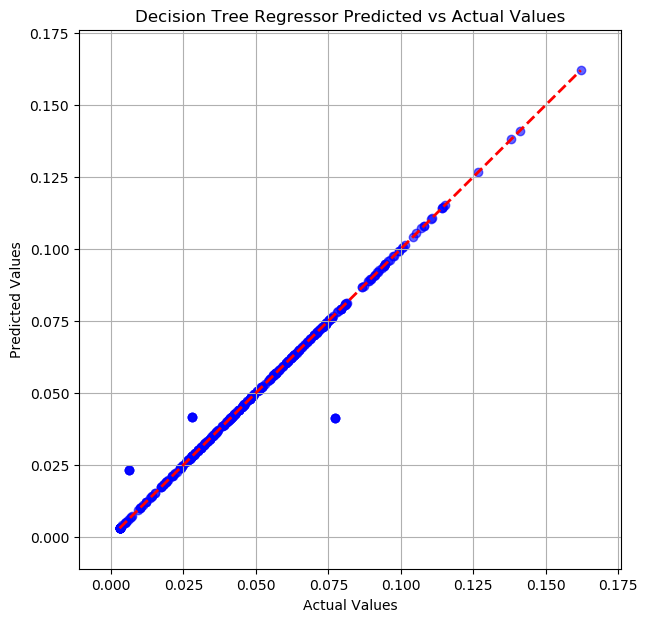

In [21]:
from sklearn.tree import DecisionTreeRegressor

modelfile = 'model/DTR.pkl'  # Updated model file for regression
if os.path.exists(modelfile):
    # Load the trained model from the file
    dt_regressor = joblib.load(modelfile)
    print("Model loaded successfully.")
    predict = dt_regressor.predict(x_test)
    calculateRegressionMetrics("Decision Tree Regressor", predict, y_test)
else:
    # Initialize and train the Gradient Boosting Regressor model
    dt_regressor = DecisionTreeRegressor(random_state=42)  # Use the regressor version
    dt_regressor.fit(x_train, y_train)
    # Save the trained model to a file
    joblib.dump(dt_regressor, modelfile) 
    print("Model saved successfully.")
    predict = dt_regressor.predict(x_test)
    calculateRegressionMetrics("Decision Tree Regressor", predict, y_test)

In [40]:
testdata = pd.read_csv('testdata.csv')
testdata

,Kernel Name,Number Of Runs,CU Full Name,Minimum Time (ms),Average Time (ms),Maximum Time (ms),DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s)
0,85,500,0,0.708,0.719,0.868,10.596,0.162,244.496
1,91,500,0,0.477,0.488,0.816,12.615,0.114,266.378
2,61,500,0,0.354,0.365,0.876,17.225,0.134,437.257
3,93,500,0,0.919,0.928,1.069,12.400,0.174,200.180
4,18,500,0,1.320,1.326,1.420,10.628,1.040,818.669
5,84,500,0,1.296,1.307,1.832,10.314,0.346,277.167
6,77,500,0,0.628,0.636,0.769,9.711,0.402,693.936
7,69,500,0,2.221,2.233,2.436,6.648,1.273,585.638
8,3,500,0,0.810,0.822,1.435,0.874,1.468,1923.635
9,8,500,0,1.270,1.281,1.509,11.472,0.374,306.474


In [41]:
pred = dt_regressor.predict(testdata)
for i, p in enumerate(pred):
    print(testdata.iloc[i])  # Print the input features
    print(f"Row {i}:************************************************** Predicted Output: {p}")

Kernel Name                85.000
Number Of Runs            500.000
CU Full Name                0.000
Minimum Time (ms)           0.708
Average Time (ms)           0.719
Maximum Time (ms)           0.868
DPU Performance(GOP/s)     10.596
Mem IO(MB)                  0.162
Mem Bandwidth(MB/s)       244.496
Name: 0, dtype: float64
Row 0:************************************************** Predicted Output: 0.032
Kernel Name                91.000
Number Of Runs            500.000
CU Full Name                0.000
Minimum Time (ms)           0.477
Average Time (ms)           0.488
Maximum Time (ms)           0.816
DPU Performance(GOP/s)     12.615
Mem IO(MB)                  0.114
Mem Bandwidth(MB/s)       266.378
Name: 1, dtype: float64
Row 1:************************************************** Predicted Output: 0.025
Kernel Name                61.000
Number Of Runs            500.000
CU Full Name                0.000
Minimum Time (ms)           0.354
Average Time (ms)           0.365
Maximum 

In [35]:
testdata['Predicted as '] = pred
testdata

,Kernel Name,Number Of Runs,CU Full Name,Minimum Time (ms),Average Time (ms),Maximum Time (ms),DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s),Predicted as
0,85,500,0,0.708,0.719,0.868,10.596,0.162,244.496,0.032
1,91,500,0,0.477,0.488,0.816,12.615,0.114,266.378,0.025
2,61,500,0,0.354,0.365,0.876,17.225,0.134,437.257,0.024
3,93,500,0,0.919,0.928,1.069,12.400,0.174,200.180,0.050
4,18,500,0,1.320,1.326,1.420,10.628,1.040,818.669,0.062
5,84,500,0,1.296,1.307,1.832,10.314,0.346,277.167,0.059
6,77,500,0,0.628,0.636,0.769,9.711,0.402,693.936,0.026
7,69,500,0,2.221,2.233,2.436,6.648,1.273,585.638,0.067
8,3,500,0,0.810,0.822,1.435,0.874,1.468,1923.635,0.003
9,8,500,0,1.270,1.281,1.509,11.472,0.374,306.474,0.065
